In [65]:
from keras import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
from keras import backend as K
from scipy.io import loadmat

## Load Data

In [66]:
img_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Image/',
    labels=None,
    class_names=None,
    image_size=(128, 128),
    shuffle=False,
    seed=42,
    batch_size=None,
    interpolation="bilinear",
)


mask_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Data/Segmentation_Mask/',
    label_mode="int",
        labels=None,
    class_names=None,
    image_size=(128, 128),
    shuffle=False,
    seed=42,
    batch_size=None,
    interpolation="bilinear",
)


Found 27460 files belonging to 1 classes.
Found 27460 files belonging to 1 classes.


In [67]:
def cast_to_int(image):
    return tf.cast(image, tf.int32)

img_train_data1 = img_data.map(cast_to_int)
mask_train_data1 = mask_data.map(cast_to_int)


In [68]:
#zip image and mask
train_data = tf.data.Dataset.zip((img_train_data1, mask_train_data1))

In [69]:
train_data

<ZipDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None))>

### test image show

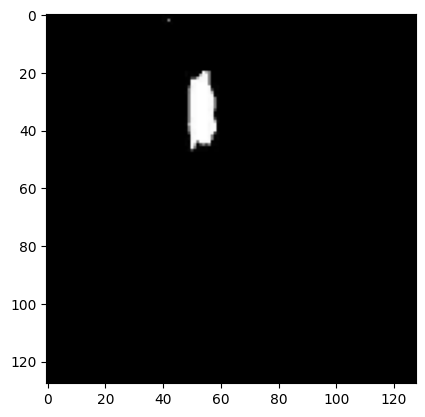

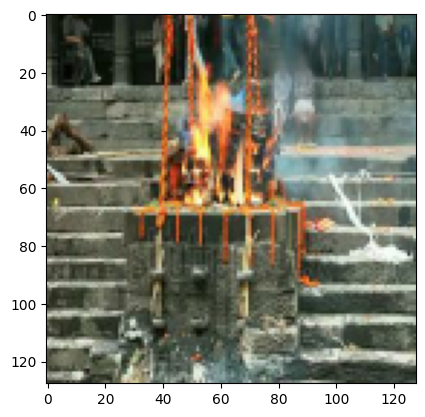

In [70]:
image, mask = next(iter(train_data))
import matplotlib.pyplot as plt

plt.imshow(mask)
plt.show()

plt.imshow(image)
plt.show()

In [71]:
#train test split
train_size = int(0.6 * 1000)
test_size = int(0.2 * 1000)
val_size = int(0.2 * 1000)

train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.take(train_size)
test_data = train_data.skip(train_size)
val_data = test_data.skip(test_size)
test_data = test_data.take(test_size)



In [72]:
train_data

<TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None))>

## Functions

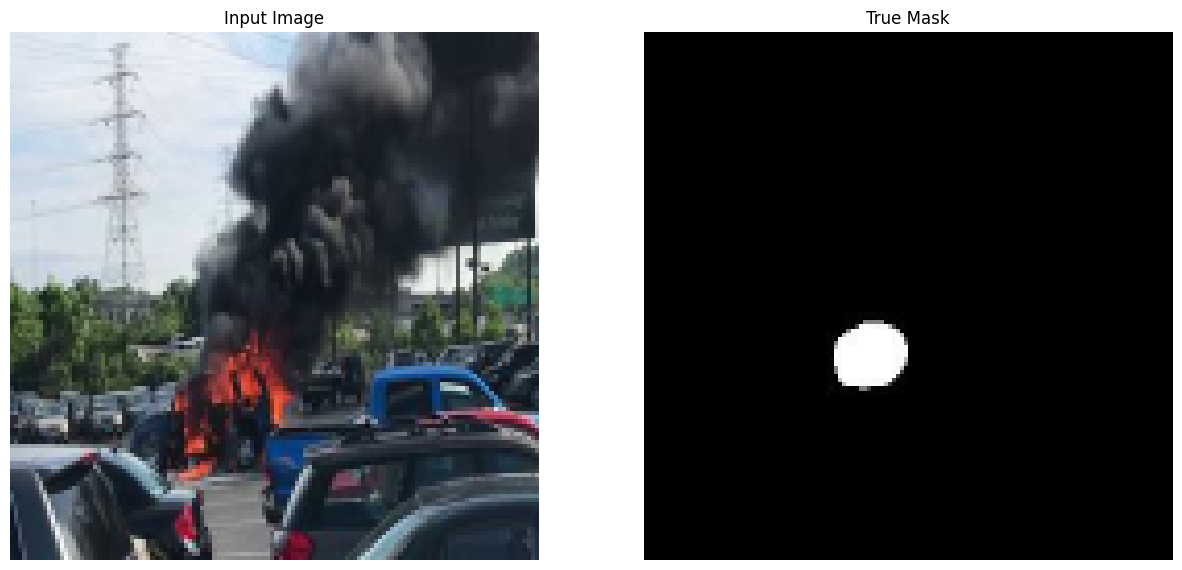

In [73]:
# function for showing sample images and its mask from the dataset
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

# train.take(1) method takes the first element f
for image, mask in train_data.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [74]:
# function to normalize the dataset,i.e the pixel value ranges from 0-1
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [75]:
# resizing the train dataset image to H x W = 128 x 128
# performing image augmentation to increase the dataset size
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [76]:
# resizing the test dataset image to H x W = 128 x 128
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [77]:
# function for showing sample images and its mask from the dataset
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

## Model 1

In [78]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [79]:
def fcn(image_size, ch_in=3, ch_out=3):
    
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    vgg16 = VGG16(include_top=False, weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', input_tensor=inputs)
    # Recovering the feature maps generated by each of the 3 final blocks:
    f3 = vgg16.get_layer('block3_pool').output  
    f4 = vgg16.get_layer('block4_pool').output  
    f5 = vgg16.get_layer('block5_pool').output  

    # Replacing VGG dense layers by convolutions:
    f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
                      activation='relu')(f5)
    f5_drop1 = Dropout(0.5)(f5_conv1)
    f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
                      activation='relu')(f5_drop1)
    f5_drop2 = Dropout(0.5)(f5_conv2)
    f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f5_drop2)


    # Using a transposed conv (w/ s=2) to upscale `f5` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1, f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8,
                              padding='same', activation=None)(merge2)
    
    fcn_model = Model(inputs, outputs)
    return fcn_model

In [80]:
# defining the tensorflow distribute strategy
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## Model 2

In [81]:
# function to create the mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [82]:
# function to show the prediction
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [83]:
# calllback to displaying the predictions of our model while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
   
 # ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)


In [84]:
BUFFER_SIZE = 27460
BATCH_SIZE = 32
train_dataset = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_data.batch(BATCH_SIZE)


In [85]:
#clear session
tf.keras.backend.clear_session()

In [86]:
def decoder(c6):
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Add()([u7, c7])

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Add()([u8, c8])

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Add()([u9, c9])

    u10 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = tf.keras.layers.Add()([u10, c10])

    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c10)
    return outputs

In [87]:
def encoder(inputs):
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.2)(c5)
    c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c5)

    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    return c6

In [88]:
inputs = tf.keras.layers.Input(shape=(None, None, 3))

encoder = encoder(inputs)
outputs = decoder(encoder)

In [89]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 dropout (Dropout)              (None, None, None,   0           ['conv2d[0][0]']                 
                                16)                                                           

In [90]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [91]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

EPOCHS = 5
VAL_SUBSPLITS = 5
train_length = 27460*0.6
STEPS_PER_EPOCH = train_length // BATCH_SIZE
# model_history = model.fit(train_dataset, epochs=EPOCHS,
#                         batch_size=BATCH_SIZE,
                        
#                         validation_data=val_dataset,
#                         callbacks=[reduce_lr, early_stopping])

# callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
#         tf.keras.callbacks.TensorBoard(log_dir='logs')]

model.fit(train_dataset, validation_data=val_dataset, batch_size=16, epochs=5,steps_per_epoch=STEPS_PER_EPOCH, callbacks=callbacks)

Epoch 1/5
858/858 [==============================] - 93s 86ms/step - loss: nan - accuracy: 0.9588
Epoch 2/5
858/858 [==============================] - 75s 87ms/step - loss: nan - accuracy: 1.0000
Epoch 3/5
858/858 [==============================] - 74s 86ms/step - loss: nan - accuracy: 1.0000
Epoch 4/5
858/858 [==============================] - 73s 85ms/step - loss: nan - accuracy: 1.0000
Epoch 5/5
858/858 [==============================] - 75s 87ms/step - loss: nan - accuracy: 1.0000


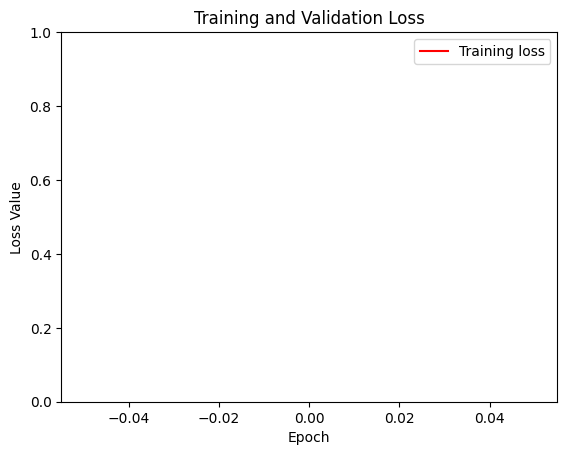

In [96]:
loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
# plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training accuracy')
plt.plot( val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [101]:
sample_image = image
sample_mask = mask

In [103]:
prediction = model.predict(sample_image[tf.newaxis, ...])[0]

1/1 [==============================] - 4s 4s/step


In [104]:
predicted_mask = (prediction > 0.5).astype(np.uint8)


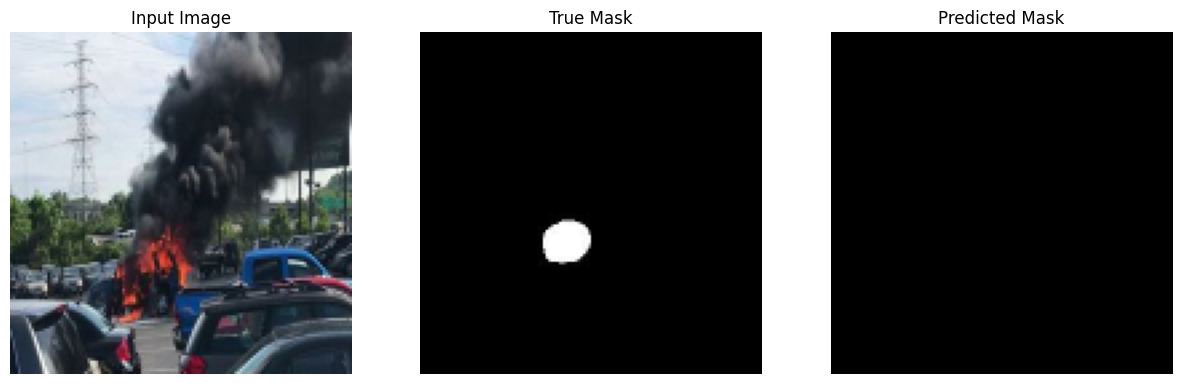

In [105]:
display([sample_image, sample_mask,predicted_mask])

## Model 3

In [128]:
def fcn(vgg, classes = 13, fcn8 = False, fcn16 = False):
    pool5 = vgg.get_layer('block5_pool').output 
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output
    
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
    
    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)
    
    if fcn8 :
        output_layer = Activation('softmax')(deconv_9)
    elif fcn16 :
        deconv_10 = Conv2DTranspose(classes, kernel_size=(16,16), strides=(16,16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
    else :
        deconv_11 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
    
    model = Model(inputs=vgg.input, outputs=output_layer)
    return model

In [130]:
vgg = VGG16(include_top=False, weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', input_shape=(128, 128, 3))


In [132]:
#clear session
K.clear_session()

In [134]:
model = fcn(vgg, fcn8=True)
model.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[7,7,512,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [124]:
train_datasetadam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.int32, name=None))>

In [135]:
filepath = "best-model-vgg.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

NameError: name 'ModelCheckpoint' is not defined

In [ ]:
callbacks.append(checkpoint)

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, batch_size=16, epochs=5,steps_per_epoch=STEPS_PER_EPOCH, callbacks=callbacks)

## Model 4